In [ ]:
#this code is runed on google colabs
!pip install torchmetrics
!pip install tqdm
!pip install torch
!pip install torchvision
!pip install TorchAudio
!pip install Cython
!pip install torchattacks
!pip install opencv-python
!pip install PIL

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing install

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch

class DresdenDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        # Initialize the dataset with the directory of images and optional transforms
        self.image_dir = image_dir
        basename = os.path.basename(image_dir)
        self.label_dir = os.path.join((os.path.dirname(image_dir)), basename, 'merged')
        self.transform = transform

        # Collect filenames of images and masks from the directory
        self.image_names = [filename for filename in os.listdir(image_dir) if filename.startswith("image")]
        self.label_names = [filename for filename in os.listdir(image_dir) if filename.startswith("mask")]

        # Sort the image and label filenames based on their numeric identifiers
        self.image_names.sort(key=lambda x: int(x[5:7]))  # Extract and sort based on the number in "imageXX.png"
        self.label_names.sort(key=lambda x: int(x[4:6]))  # Extract and sort based on the number in "maskXX.png"

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.image_names)

    def classes(self):
        # Define the classes in the dataset
        return torch.Tensor([0, 1])

    def __getitem__(self, idx):
        # Retrieve an item by its index
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load the image and its corresponding label
        image = np.array(Image.open(os.path.join(self.image_dir, self.image_names[idx])).convert('RGB'))
        label1 = np.array(Image.open(os.path.join(self.image_dir, self.label_names[idx])).convert('RGB'))

        # Process the label image to create binary mask labels
        label = np.zeros(np.shape(label1), np.uint8)[:, :, 0:2]
        label[:, :, 0][label1[:, :, 0] > 125] = 1  # Assign class 1 to pixels with a value > 125 in the red channel
        label[:, :, 1][label1[:, :, 0] < 125] = 1  # Assign class 1 to pixels with a value < 125 in the red channel

        # Create a dictionary with the processed image and label
        dictionary = {'image0': image, 'image1': label}

        # Apply transforms, if any
        if self.transform is not None:
            dictionary = self.transform(dictionary)

        return dictionary


In [ ]:
import torch
import torch.nn as nn

'''
UResNet Class: Combines U-Net and ResNet architectures for segmentation tasks. It includes both contracting (downward) and expanding (upward) paths with long skip connections.
Constructor (__init__): Initializes layers and sets up the network structure.
Forward Method: Defines how the input data flows through the network, including the integration of long skip connections.
_make_layer Method: Helper function to create layers of blocks (either standard or bottleneck).
Factory Functions (UResNet18, UResNet34, etc.): These functions provide easy creation of UResNet models with different depths.
Test Function: A simple function to verify the model's output dimensions.
'''
# Custom Sequential class to handle multiple inputs
class mySequential(nn.Sequential):
    def forward(self, *inputs):
        for module in self._modules.values():
            # If inputs is a tuple, apply the module to all elements in the tuple
            if type(inputs) == tuple:
                inputs = module(*inputs)
            else:
                inputs = module(inputs)
        return inputs

class block_standard(nn.Module):
    # Block expansion factor for standard blocks
    expansion: int = 1
    # Factor to adjust the out_channels in standard blocks
    out_multiply: int = 2

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1, up=False):
        super(block_standard, self).__init__()
        self.up = up
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Convolutional layers setup, with or without transpose (upscaling)
        if self.up:
            # For upscaling
            self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=stride, stride=stride)
        else:
            # Regular convolution
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x, long_skip=None):
        identity = x
        # Forward pass through layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        # Apply identity downsample if exists
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        # Concatenate with long skip connection if exists
        if long_skip is not None:
            x = torch.cat((x, long_skip), dim=1)
        x += identity
        x = self.relu(x)

        del identity  # Explicit memory management

        return x, long_skip


class block_bottleneck(nn.Module):
    # Block expansion factor for bottleneck blocks
    expansion: int = 4
    # Factor to adjust the out_channels in bottleneck blocks
    out_multiply: int = 1

    def __init__(self, in_channels, out_channels, identity_scale=None, stride=1, up=False):
        super(block_bottleneck, self).__init__()
        self.up = up
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Adjust expansion factor based on upscaling
        self.expansion = 2 if self.up else 4

        # Convolutional layers setup, with or without transpose (upscaling)
        if self.up:
            self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=stride, stride=stride)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        if self.up:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        else:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_scale = identity_scale

    def forward(self, x, long_skip=None):
        identity = x
        # Forward pass through layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        # Apply identity scale if exists
        if self.identity_scale is not None:
            identity = self.identity_scale(identity)

        # Concatenate with long skip connection if exists
        if long_skip is not None:
            x = torch.cat((x, long_skip), dim=1)
        x += identity
        x = self.relu(x)

        del identity  # Explicit memory management

        return x, long_skip
    
class UResNet(nn.Module): 
    # UResNet: U-Net combined with ResNet architecture. 
    # Designed for segmentation tasks with deep feature extraction.

    def __init__(self, block, layers, image_channels, num_classes):
        # Initialize UResNet model
        # Parameters:
        #   block: Type of block to use (standard or bottleneck)
        #   layers: List indicating the number of blocks at each layer
        #   image_channels: Number of input channels (e.g., 3 for RGB images)
        #   num_classes: Number of output classes for segmentation

        super(UResNet, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Placeholder for long skip connections
        self.long_skip = []

        # Constructing downward (contracting) path using ResNet layers
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        # Constructing upward (expanding) path using ResNet layers
        self.layer5 = self._make_layer(block, layers[3], out_channels=512, stride=2, up=True)
        self.layer6 = self._make_layer(block, layers[2], out_channels=256, stride=2, up=True)
        self.layer7 = self._make_layer(block, layers[1], out_channels=128, stride=2, up=True)
        self.layer8 = self._make_layer(block, layers[0], out_channels=64, stride=1)

        # Final convolutional layers to refine the output
        self.conv_last1 = nn.ConvTranspose2d(self.in_channels, 64, kernel_size=2, stride=2, padding=0)
        self.conv_last2 = nn.ConvTranspose2d(64*2, num_classes, kernel_size=2, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(num_classes)
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass of UResNet
        # x: Input tensor

        # Initial layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Storing feature maps for long skip connections
        self.long_skip = [0, 0, 0, 0]
        self.long_skip[0] = x
        x = self.maxpool(x)

        # Downward path
        x, temp = self.layer1(x, None)
        self.long_skip[1] = x
        x, temp = self.layer2(x, None)
        self.long_skip[2] = x
        x, temp = self.layer3(x, None)
        self.long_skip[3] = x
        x, temp = self.layer4(x, None)

        # Reverse the order of long skips for upward path
        self.long_skip = self.long_skip[::-1]

        # Upward path with long skip connections
        x, temp = self.layer5(x, self.long_skip[0])
        x, temp = self.layer6(x, self.long_skip[1])
        x, temp = self.layer7(x, self.long_skip[2])
        x, temp = self.layer8(x, None)

        # Final layers to produce the segmentation map
        x = self.conv_last1(x)
        x = self.bn1(x)
        x = torch.cat((x, self.long_skip[3]), dim=1)
        x = self.relu(x)
        x = self.conv_last2(x)
        x = self.bn2(x)
        x = self.Softmax(x)

        # Clean up to save memory
        del self.long_skip, temp

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride, up=False):
        # Helper method to create a layer of blocks
        # Parameters:
        #   block: The type of block (standard or bottleneck)
        #   num_residual_blocks: Number of blocks in the layer
        #   out_channels: Number of output channels
        #   stride: Stride for convolutional layers
        #   up: Flag to indicate if this is an upward (True) or downward (False) layer

        identity_scale = None
        layers = []

        # Downward path construction
        if not up:
            # Adjust identity mapping for residual connections if needed
            if stride != 1 or self.in_channels != out_channels*block.expansion:
                identity_scale = mySequential(
                    nn.Conv2d(self.in_channels, out_channels*block.expansion, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(out_channels*block.expansion)
                )

            layers.append(block(self.in_channels, out_channels, identity_scale, stride))
            self.in_channels = out_channels*block.expansion

            for i in range(num_residual_blocks - 1):
                layers.append(block(self.in_channels, out_channels))

        # Upward path construction
        else:
            # Adjust identity mapping for residual connections in upward layers
            if stride != 1 or self.in_channels != out_channels*block.expansion:
                identity_scale = mySequential(
                    nn.ConvTranspose2d(self.in_channels, out_channels*block.expansion, kernel_size=stride, stride=stride),
                    nn.BatchNorm2d(out_channels*block.expansion)
                )
            # Adjust out_channels for standard block
            out_channels = int(out_channels / block.out_multiply)
            layers.append(block(self.in_channels, out_channels, identity_scale, stride, up=True))

            # Update in_channels based on block type and expansion
            if stride == 1 and up:
                self.in_channels = out_channels * 2
            elif block.expansion == 1 and up:
                self.in_channels = out_channels * 2
            else:
                self.in_channels = out_channels * 4

            for i in range(num_residual_blocks - 1):
                layers.append(block(self.in_channels, out_channels, up=True))

        return mySequential(*layers)

# Factory functions to create UResNet models with different configurations
def UResNet18(in_channels=3, num_classes=1000):
    # Returns a UResNet18 model
    return UResNet(block_standard, [2, 2, 2, 2], in_channels, num_classes)

def UResNet34(in_channels=3, num_classes=1000):
    # Returns a UResNet34 model
    return UResNet(block_standard, [3, 4, 6, 3], in_channels, num_classes)

def UResNet50(in_channels=3, num_classes=1000):
    # Returns a UResNet50 model
    return UResNet(block_bottleneck, [3, 4, 6, 3], in_channels, num_classes)

def UResNet101(in_channels=3, num_classes=1000):
    # Returns a UResNet101 model
    return UResNet(block_bottleneck, [3, 4, 23, 3], in_channels, num_classes)

def UResNet152(in_channels=3, num_classes=1000):
    # Returns a UResNet152 model
    return UResNet(block_bottleneck, [3, 8, 36, 3], in_channels, num_classes)

def test():
    # Test function to verify the model output
    net = UResNet18()
    x = torch.randn(2, 3, 224, 224)  # Dummy input
    if torch.cuda.is_available():
        y = net(x).to('cuda')
    else:
        y = net(x)
    print(y.shape)  # Print the output shape for verification

if __name__ == '__main__':
    test()


torch.Size([2, 1000, 224, 224])


In [ ]:
'''
This file is used together with the 'train.py' file to help in the training and
testing process with util functions.
'''
import torch
#from dataset import DresdenDataset
from torch.utils.data import DataLoader, random_split
import torchvision.transforms.functional as tf
from torchvision.transforms import Compose
from torchvision.utils import save_image
from tqdm import tqdm
import random
from torchmetrics import Dice


# The next functions are functional transforms, used to apply functions in a way
# controled by the user. So we can apply, for example, in the data image and in
# the label image (so it is called deterministic, because we can determine the
# same transformation to be applied in more then one image). This is the unique
# way to apply the same transformation to more then one different image in torch

class ToTensor(object):
    '''Function to transform a ndarray in a tensor

    n: int (input)
        number of non-mask images to convert to tensor (the rest will be
        converted without scaling to [0.0,1.0])'''
    def __init__(self, n):
        self.n = n

    def __call__(self, images):
        for i, image in enumerate(images):
            if i < self.n:
                images[image] = tf.to_tensor(images[image])
            else:
                images[image] = torch.from_numpy(images[image])
                images[image] = torch.permute(images[image], (2,0,1))

        return images


class Rotate(object):
    '''Function to rotate an image, the input is a dictionary

    images: 'dictionary' (input)
        dictionary with images;
    limit: 'list'
        a list 'int' with smaller and larger angles to rotate (e.g. [0, 90]);
    p: 'float'
        probability to rotate;

    dictionary: 'dictionary' (output)
        dictionary with cropped images with keys 'image0', 'image1', etc.
    '''
    def __init__(self,**kwargs):
        # 'limit' is a 'list' that defines the lower and upper angular limits
        limit = kwargs.get('limit')
        if not limit: limit = [0, 360]
        self.limit = limit
        # 'p' is 'float' the probability to happen a rotate
        p = kwargs.get('p')
        if not p: p = 0.5
        self.p = p

    def __call__(self, images):
        if random.random() > 1-self.p:
            angle = random.randint(self.limit[0], self.limit[1])
            for i, image in enumerate(images):
                images[image] = tf.rotate(images[image], angle)

        return images


class CenterCrop(object):
    '''Function to center crop one or multiple images

    size: 'list' (input)
        input list with size (e.g. '[400,200]');
    images: 'dictionary' (input) (output)
        dictionary with images.
    '''
    def __init__(self, size):
        self.size = size


    def __call__(self, images):
        for image in images:
            images[image] = tf.center_crop(images[image], self.size)

        return images


class Resize(object):
    '''Function to resize one or multiple images

    size: 'list' (input)
        input list with size (e.g. '[400,200]');
    images: 'dictionary' (input) (output)
        dictionary with images.
    '''
    def __init__(self, size):
        self.size = size

    def __call__(self, images):
        for image in images:
            images[image] = tf.resize(images[image], self.size)

        return images


class FlipHorizontal(object):
    '''Horizontally flip images randomly

    p: 'float' (input)
        probability to flip (from 0.0 to 1.0).
    '''
    def __init__(self, p):
        self.p = p

    def __call__(self, images):
        if random.random() > 1-self.p:
            for image in images:
                images[image] = tf.hflip(images[image])

        return images


class FlipVertical(object):
    '''Vertically flip images randomly

    p: 'float' (input)
        probability to flip (from 0.0 to 1.0).
    '''
    def __init__(self, p):
        self.p = p

    def __call__(self, images):
        if random.random() > 1-self.p:
            for image in images:
                images[image] = tf.vflip(images[image])

        return images


class Normalize(object):
    '''Normalizing 'n' images of a given set of images

    n: int (input)
        number of images to normalize;
    mean: list (input)
        mean to normalize;
    std: list (input)
        stadard deviation to normalize.
    '''
    def __init__(self, n=1, mean=0.5, std=0.5):
        self.n = n
        self.mean = mean
        self.std = std

    def __call__(self, images):
        for i, image in enumerate(images):
            if i < self.n:
                images[image] = tf.normalize(images[image], self.mean, self.std)

        return images


class Affine(object):
    '''Affining images

    size: list (input)
        maximum higher and width to translate image (normally the image size);
    scale: float (input)
        scale to perform affine (between 0 and 1.0);
    p: float (input)
        probability to thange.'''
    def __init__(self, size=[0,0], scale=0.5, p=0.5):
        self.size = size
        self.scale = scale
        self.p = p

    def __call__(self, images):
        if random.random() > 1-self.p:
            angle = random.random()*self.scale*360
            shear = random.random()*self.scale*360
            translate = [i*random.random()*self.scale for i in self.size]
            for image in images:
                images[image] = tf.affine(images[image], angle=angle,
                                         translate=translate, scale=1-self.scale,
                                         shear=shear)
        return images


#%% Util Functions to be Used During Training or Testing

# saving checkpoints
def save_checkpoint(state, filename='my_checkpoint.pth.tar'):
    print('\n- Saving Checkpoint...')
    torch.save(state, filename)

# loading checkpoints
def load_checkpoint(checkpoint, model, optimizer=None):
    print('\n- Loading Checkpoint...')
    model.load_state_dict(checkpoint['state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer'])

# getting loaders given directories and other informations
def get_loaders(train_image_dir,
                valid_percent,
                test_percent,
                batch_size,
                image_height,
                image_width,
                num_workers=1,
                pin_memory=True,
                val_image_dir=None,
                clip_valid=1.0,
                clip_train=1.0):

    # first, defining transformations to be applied in the train images to be loaded
    transform_train_0 = Compose([ToTensor(n=1),
                                 Resize(size=[image_height, image_width]),
                                 FlipVertical(p=0.5),
                                 FlipHorizontal(p=0.5),
                                 # mean and std, obtained from Dresden Dataset
                                 # for segmentation
                                 Normalize(n=1, mean=[0.4338, 0.31936, 0.312387],
                                           std=[0.1904, 0.15638, 0.15657])]
                                )
    # defining the same, but for validation and testing images (can be different)
    transform_valid_0 = Compose([ToTensor(n=1),
                                 Resize(size=[image_height, image_width]),
                                 FlipVertical(p=0.5),
                                 FlipHorizontal(p=0.5),
                                 # defining again if validation dataset is dif.
                                 Normalize(n=1, mean=[0.4338, 0.31936, 0.312387],
                                           std=[0.1904, 0.15638, 0.15657])]
                                )

    # second, defining the number of transformations per directory in
    # 'train_image_dir' defines the data augmantation (1 for no augmentation
    # and 5 for 5 times augmentation)
    transformations_per_dataset = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                                   5, 5, 5, 5, 5, 5]

    # third, reading the dataset in a as a 'torch.utils.data.Dataset' instance.
    # it is only for images in 'train_image_dir[0]', further we will accounts
    # for the rest of the directories
    train_dataset = DresdenDataset(image_dir=train_image_dir[0],
                                  transform=transform_train_0)
    print("train_dataset:",train_dataset)

    # concatenate the other directories in 'train_image_dir[:]' in a larger
    # 'torhc.utils.data.Dataset'. after we will concatenate more for augmentat.
    for n in range(1, len(train_image_dir)):
        dataset_train_temp = DresdenDataset(image_dir=train_image_dir[n],
                                           transform=transform_train_0)
        # to use 'train_dataset' here in right, we have to define it before
        train_dataset = torch.utils.data.ConcatDataset([train_dataset,
                                                        dataset_train_temp])

    # using part of the training data as test dataset
    test_dataset_size = int(test_percent*len(train_dataset))
    rest_size = int((1-test_percent)*len(train_dataset))
    if test_dataset_size+rest_size != len(train_dataset):
        rest_size += 1
    (test_dataset, _) = random_split(train_dataset, [test_dataset_size, rest_size],
                                     generator=(torch.Generator().manual_seed(40)))

    # defining the validation dataset, using part of the 'train_dataset', or
    # using a specific dataset for validation, if 'val_image_dir' is not 'None'
    if not val_image_dir:
        valid_dataset_size = int(valid_percent*len(train_dataset))
        train_dataset_size = int((1-valid_percent)*len(train_dataset))
        # adding one to train_dataset_size if 'int' operation removed it
        if valid_dataset_size+train_dataset_size != len(train_dataset):
            train_dataset_size += 1
        (train_dataset, valid_dataset) = random_split(train_dataset,
                                         [train_dataset_size, valid_dataset_size],
                                         generator=torch.Generator().manual_seed(20))
    else:
        valid_dataset = DresdenDataset(image_dir=val_image_dir[0],
                                      transform=transform_valid_0)
        for n in range(1, len(val_image_dir)):
            dataset_val_temp = DresdenDataset(image_dir=val_image_dir[n],
                                             transform=transform_valid_0)
            valid_dataset = torch.utils.data.ConcatDataset([valid_dataset,
                                                            dataset_val_temp])

    # concatenating the augmented data, in case 'transf..._per_dataset' > 1
    for n in range(0,len(train_image_dir)):
        for m in range(1, transformations_per_dataset[n]):
            # first we specify the transformation (depending on the 'm' value)
            if m < 2:
                transformation = Compose([ToTensor(n=1),
                                          Rotate(limit=[(m-1)*72,m*72], p=1.0),
                                          Resize(size=[image_height, image_width]),
                                          FlipVertical(p=0.5),
                                          FlipHorizontal(p=0.5),
                                          # Mean and std, obtained from the dataset
                                          Normalize(n=1, mean=[0.4338, 0.31936, 0.312387],
                                                    std=[0.1904, 0.15638, 0.15657])]
                                          )
            else:
                transformation = Compose([ToTensor(n=1),
                                          Affine(size=[0.5*image_height, 0.5*image_width],
                                                 scale=0.01*(m-1), p=0.5),
                                          Rotate(limit=[(m-1)*72,m*72], p=1.0),
                                          Resize(size=[image_height, image_width]),
                                          FlipVertical(p=0.5),
                                          FlipHorizontal(p=0.5),
                                          # Mean and std, obtained from the dataset
                                          Normalize(n=1, mean=[0.4338, 0.31936, 0.312387],
                                                    std=[0.1904, 0.15638, 0.15657])]
                                          )
            # then we apply this transformation to read the dataset as 'torch.utils.data.Dataset'
            dataset_train_temp = DresdenDataset(image_dir=train_image_dir[n],
                                               transform=transformation)
            train_dataset = torch.utils.data.ConcatDataset([train_dataset, dataset_train_temp])

    # splitting the dataset, to deminish if 'clip_valid'<1 for fast testing
    if clip_train < 1:
        print('\n- Splitting Training Dataset ',clip_train*100,'%')
        train_mini = int(clip_train*len(train_dataset))
        temp_mini = int((1-clip_train)*len(train_dataset))
        if train_mini+temp_mini != len(train_dataset):
            temp_mini += 1
        (train_dataset, _) = random_split(train_dataset,[train_mini, temp_mini],
                                          generator=torch.Generator().manual_seed(40))
    if clip_valid < 1:
        print('\n- Splitting Validation Dataset ',clip_valid*100,'%')
        valid_mini = int(clip_valid*len(valid_dataset))
        temp_mini = int((1-clip_valid)*len(valid_dataset))
        if valid_mini+temp_mini != len(valid_dataset):
            temp_mini += 1
        (valid_dataset, _) = random_split(valid_dataset,[valid_mini, temp_mini],
                                          generator=torch.Generator().manual_seed(30))
        (test_dataset, _) = random_split(test_dataset, [valid_mini, temp_mini],
                                         generator=torch.Generator().manual_seed(50))

    # obtaining dataloader from the datasets defined above
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              num_workers=num_workers,
                              pin_memory=pin_memory, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                              num_workers=num_workers,
                              pin_memory=pin_memory)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size,
                              num_workers=num_workers,
                              pin_memory=pin_memory)

    return train_loader, test_loader, valid_loader

# functino to check accuracy
def check_accuracy(loader, model, loss_fn, device='cuda' if torch.cuda.is_available() else 'cpu', **kwargs):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    # if title is passed, use it before 'Check acc' and 'Got an accuracy...'
    title = kwargs.get('title')
    if title==None: title = ''
    else: title = title+': '
    # using tqdm.tqdm to show a progress bar
    loop = tqdm(loader, desc=title+'Check acc')

    with torch.no_grad():
        for dictionary in loop:
            image, label = dictionary
            x, y = dictionary[image], dictionary[label]
            x, y = x.to(device=device), y.to(device=device)
            y = y.float()
            pred = model(x)
            y = tf.center_crop(y, pred.shape[2:])
            pred = (pred > 0.5).float()
            loss = loss_fn(pred, y)
            num_correct += (pred == y).sum()
            num_pixels += torch.numel(pred)
            # next is to calculate dice-score
            pred = pred.to(device='cpu').to(torch.int32)
            y = y.to(device='cpu').to(torch.int32)
            dice = Dice(ignore_index=0)
            dice_score += dice(pred, y)
            loop.set_postfix(acc=str(round(100*num_correct.item()/int(num_pixels),4)))
            # deliting variables
            loss_item = loss.item()
            del loss, pred, x, y, image, label, dictionary
    # deliting variables
    num_correct_item = num_correct.item()
    num_pixels = int(num_pixels)
    dice_score_item = dice_score.item()
    len_loader = len(loader)
    del num_correct, dice_score, loader, loop

    print('\n'+title+f'Got an accuracy of {round(100*num_correct_item/int(num_pixels),4)}')

    print('\n'+title+f'Dice score: {round(100*dice_score_item/len_loader,4)}'+'\n')
    model.train()
    return 100*num_correct_item/num_pixels, loss_item, 100*dice_score_item/len_loader

# saving images (only if the output are images)
def save_predictions_as_imgs(loader, model, folder='saved_images',
                             device='cuda' if torch.cuda.is_available() else 'cpu',
                             **kwargs):
    # If image is grayscale, if yes, we have to turn into rgb to save
    gray = kwargs.get('gray')
    # With model in evaluation
    model.eval()
    for idx, (dictionary) in enumerate(loader):
        image, label = dictionary
        x, y = dictionary[image], dictionary[label]
        x = x.to(device=device)
        y = y.to(dtype=torch.float32)
        y = y.to(device=device)
        with torch.no_grad():
            pred = model(x)
            y = tf.center_crop(y, pred.shape[2:])
            pred = (pred > 0.5).float()
        # If image is grayscale, transforming to 'rgb' (utils.save_image needs)
        if gray:
            pred = torch.cat([pred,pred,pred],1)
            y = y.unsqueeze(1)
            y = torch.cat([y,y,y],1)
            y = y.float()
            y = tf.center_crop(y, pred.shape[2:])
        save_image(pred, f'{folder}/pred_{idx}.png')
        save_image(y, f'{folder}/y_{idx}.png')

    model.train()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
train_dataset: <__main__.DresdenDataset object at 0x78babdabff40>


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



- Loading Checkpoint...


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 78.7037

Dice score: 79.5626


- Continue Training...


- Loading Checkpoint...


Epoch 8:   0%|          | 0/578 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL


- Saving Checkpoint...

Validating:


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 81.8654

Dice score: 82.4204

Testing:


Check acc:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 78.9472

Dice score: 79.4599


- Time taken: 117.519 min

- Last Learning rate: 0.00043047 




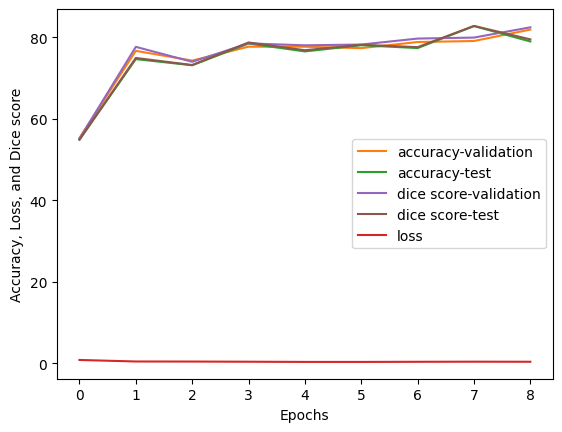

Epoch 9:   0%|          | 0/578 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL


- Saving Checkpoint...

Validating:


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 85.217

Dice score: 85.7663

Testing:


Check acc:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 80.1321

Dice score: 80.6962


- Time taken: 131.066 min

- Last Learning rate: 0.00038742 




Epoch 10:   0%|          | 0/578 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


- Saving Checkpoint...

Validating:


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 80.6496

Dice score: 81.3147

Testing:


Check acc:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 78.5461

Dice score: 78.7411


- Time taken: 144.583 min

- Last Learning rate: 0.00034868 




Epoch 11:   0%|          | 0/578 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


- Saving Checkpoint...

Validating:


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 81.66

Dice score: 81.7954

Testing:


Check acc:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 75.1744

Dice score: 75.3911


- Time taken: 158.133 min

- Last Learning rate: 0.00031381 




Epoch 12:   0%|          | 0/578 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


- Saving Checkpoint...

Validating:


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 82.4854

Dice score: 83.098

Testing:


Check acc:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 79.6688

Dice score: 80.1422


- Time taken: 171.488 min

- Last Learning rate: 0.00028243 




Epoch 13:   0%|          | 0/578 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


- Saving Checkpoint...

Validating:


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 83.4602

Dice score: 83.948

Testing:


Check acc:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 79.4539

Dice score: 79.5696


- Time taken: 185.095 min

- Last Learning rate: 0.00025419 




Epoch 14:   0%|          | 0/578 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


- Saving Checkpoint...

Validating:


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 79.967

Dice score: 80.5039

Testing:


Check acc:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 78.0893

Dice score: 78.6845


- Time taken: 198.452 min

- Last Learning rate: 0.00022877 




Epoch 15:   0%|          | 0/578 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


- Saving Checkpoint...

Validating:


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 83.6484

Dice score: 84.2932

Testing:


Check acc:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 80.3957

Dice score: 80.9761


- Time taken: 211.985 min

- Last Learning rate: 0.00020589 




Epoch 16:   0%|          | 0/578 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


- Saving Checkpoint...

Validating:


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 83.4254

Dice score: 84.0319

Testing:


Check acc:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 81.3694

Dice score: 81.9751


- Time taken: 225.745 min

- Last Learning rate: 0.0001853 




Epoch 17:   0%|          | 0/578 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


- Saving Checkpoint...

Validating:


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 82.749

Dice score: 83.2806

Testing:


Check acc:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 82.0431

Dice score: 82.5918


- Time taken: 239.394 min

- Last Learning rate: 0.00016677 




Epoch 18:   0%|          | 0/578 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


- Saving Checkpoint...

Validating:


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 82.3093

Dice score: 82.9313

Testing:


Check acc:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 78.4338

Dice score: 79.077


- Time taken: 253.151 min

- Last Learning rate: 0.00015009 




Epoch 19:   0%|          | 0/578 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


- Saving Checkpoint...

Validating:


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 83.6308

Dice score: 84.2486

Testing:


Check acc:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 80.1716

Dice score: 80.7613


- Time taken: 266.924 min

- Last Learning rate: 0.00013509 




Epoch 20:   0%|          | 0/578 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


- Saving Checkpoint...

Validating:


Check acc:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 79.5458

Dice score: 80.3123

Testing:


Check acc:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI


Got an accuracy of 78.8385

Dice score: 79.3413


- Time taken: 280.651 min

- Last Learning rate: 0.00012158 




In [ ]:
"""
Algorithm to Train, Save and Continue Training of Segmentation Models

This is a training algorithm for segmentation tasks, that can be used to
perform five tasks (training, saving, and testing models, but alose continue a
training and saving image examples comparing prediction and label) in a diverse
range of models. Next we will see which are the specific models applied using
these algorithms, but we can adapt them to train a range of other segmenta-
tion models, with just small changes (for classification models, please refers
to the algorithms in the folder 'Classification\train.py').

This program runs together with the files 'utils.py', 'model.py' and 'dataset.
py' to perform the training of the UResNet models (from 18 to 152 layers, as
specified at 'model.py'), which are based in the encoder-decoder architecture,
(see torch documentation for more information at
https://pytorch.org/tutorials/beginner/basics/data_tutorial).

Standard Training: To train a model from zero (or from the first epoch), just
define the hyperparameters, as needed, and choose 'continue_training = False',
and 'last_epoch = 0' (parameter only used for continue a training). In order to
save your model, change 'save_model' to True, and to save images resultesd from
the segmentaiton (from the validation dataset), in the folder 'saved_images'
inside the 'root_folder', change 'save_images' to True. Variables 'test_model'
and 'load_model' are for other popouses (see options below), and can set to
False during the first training.

Continue a Training: set 'continue_training = True' in the hyperparameters to
continue a training, also setting 'last_epoch' with the number of epochs
already trained (e.g. if you trained 10 epochs, and want to continue, set
'last_epoch = 10'. Also the name of the pre-trained model has to exactly match
chekpoint_dir in the 'root_folder' directory, and the 'csv' file with
previous results, 'dictionary.csv', also has to be in 'root_folder'. The varia-
ble 'laod_model' does not need to be 'True' (it is just to test, see below).

Testing models: If you only want to test one or more models, just set
'test_models = True', and specify the directory where the models to be tested
are as a string in the variable 'test_models_dir'. If other options are also
chosen, the test will take place in the and, after the other options finish.

Loading and Testing One Model: if you want to test a model before continue a
training, or just wants to load and test one model, choose 'load_model = True'.
This will test the model chekpoint_dir stored in the 'root_folder'.


Find more on the GitHub Repository:
https://github.com/MarlonGarcia/attacking-white-blood-cells


@author: THALES PIMENTEL ZUANAZZI
@instit: UNESP

code built on previus work from:

@author: Marlon Rodrigues Garcia
@instit: University of São Paulo



  A B C D
1 1 1 1 1
2 1 2 2 3
3 1 3 3 2
4 2 1 2 2
5 2 2 3 1
6 2 3 1 3
7 3 1 3 3
8 3 2 1 2
9 3 3 2 1
"""

"""
B = learning_rate = 5e-4 1e-3 1e-4
A = batch_size = 8 6 12
C = model = UResNet34(in_channels=3, num_classes=2).to(device) UResNet18(in_channels=3, num_classes=2).to(device) UResNet50(in_channels=3, num_classes=2).to(device)
D = loss = nn.CrossEntropyLoss()  CustomLoss()   nn.L1Loss()
"""

### Program  Header

import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tf
import numpy as np
import pandas as pd
import time

# running on Colabs, mounting drive
run_on_colabs = True
# Importing Drive
from google.colab import drive
drive.mount('/content/gdrive')
# To import add current folder to path (import py files):
import sys
root_folder = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal'
#              /content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal
sys.path.append(root_folder)
test_models_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal'
chekpoint_dir = 'my_checkpoint10.pth.tar'

# defining where to save results
save_results_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal'
import os
os.chdir(root_folder)

#from model import *
#from utils import *

# defining the paths to datasets
train_image_dir = ['/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/01',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/02',
                      #  '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/03',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/04',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/05',
                       #'/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/abdominal_wall/06',
                       #'/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/abdominal_wall/07',
                       #'/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/pancreas/08',
                       #'/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/abdominal_wall/09',
                       #'/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/abdominal_wall/10',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/11',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/12',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/13',
                       #'/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/abdominal_wall/14',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/15',
                       #'/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/abdominal_wall/16',
                       #'/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/abdominal_wall/17',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/18',
                       #'/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/abdominal_wall/19',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/20',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/21',
                      #  '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/22',
                       #'/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/abdominal_wall/23',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/24',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/25',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/26',
                       #'/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/pancreas/27',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/28',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/29',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/30',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/31'
                       ]

val_image_dir = ['/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/03',
                       '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Datasets/DSAD/liver/22'
                       ]


#%% Training Function

# defining the training function
def train_fn(loader, model, optimizer, loss_fn, scaler, schedule, epoch, last_lr):
    loop = tqdm(loader, desc='Epoch '+str(epoch+1))

    for batch_idx, (dictionary) in enumerate(loop):
        image, label = dictionary
        x, y = dictionary[image], dictionary[label]
        x, y = x.to(device=device), y.to(device=device)
        y = y.float()
        # forward
        with torch.cuda.amp.autocast() if torch.cuda.is_available() else torch.autocast('cpu'):
            pred = model(x)
            # cropping 'pred' for when the model changes the image dimensions
            y = tf.center_crop(y, pred.shape[2:])
            # calculating loss
            loss = loss_fn(pred, y)

        # backward
        optimizer.zero_grad()
        if device == 'cuda':
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scale = scaler.get_scale()
            scaler.update()
        # if device='cpu', we cannot use 'scaler=torch.cuda.amp.GradScaler()':
        else:
            loss.backward()
            optimizer.step()
        # freeing space by deliting variables
        loss_item = loss.item()
        del loss, pred, y, x, image, label, dictionary
        # updating tgdm loop
        loop.set_postfix(loss=loss_item)
    # deliting loader and loop
    del loader, loop
    # scheduling the learning rate and saving its last value
    if scaler:
        if scale >= scaler.get_scale():
            schedule.step()
            last_lr = schedule.get_last_lr()
    else:
        schedule.step()
        last_lr = schedule.get_last_lr()

    return loss_item, last_lr


class CustomLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        super(CustomLoss, self).__init__()
        self.alpha = alpha  # Weight for true positive loss
        self.beta = beta   # Weight for false negative loss

    def forward(self, predictions, targets):
        # Assuming predictions and targets are binary (0 or 1)
        # Calculate true positives
        true_positives = (predictions * targets)

        # Calculate false negatives
        false_negatives = ((1 - predictions) * targets)

        # Compute loss based on true positives and false negatives
        true_positive_loss = torch.mean((true_positives - targets) ** 2)
        false_negative_loss = torch.mean((false_negatives) ** 2)

        # Total loss with weighted components
        loss = (self.alpha * true_positive_loss) + (self.beta * false_negative_loss)

        return loss

#%% Defining The main() Function
model1 = UResNet34(in_channels=3, num_classes=2).to('cuda')
loss1 = CustomLoss()
def main():
    model = model1
    loss_fn = loss1
    optimizer = optim.Adam(model.parameters())
    schedule = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # loading dataLoaders
    train_loader, test_loader, valid_loader = get_loaders(
        train_image_dir=train_image_dir,
        valid_percent=valid_percent,
        test_percent=test_percent,
        batch_size=batch_size,
        image_height=image_height,
        image_width=image_width,
        num_workers=num_workers,
        pin_memory=pin_memory,
        val_image_dir=val_image_dir,
        clip_valid=clip_valid,
        clip_train=clip_train
    )

    # if this program is just to load and test a model, next it loads a model
    if load_model:
        # loading checkpoint
        os.chdir(root_folder)
        if device == 'cuda':
            load_checkpoint(torch.load(chekpoint_dir), model)
        # if 'cpu', we need to pass 'map_location'
        else:
            load_checkpoint(torch.load(chekpoint_dir,
                                       map_location=torch.device('cpu')), model)
        check_accuracy(valid_loader, model, loss_fn, device=device)

    if not load_model or continue_training:
        # changing folder to save dictionary
        os.chdir(save_results_dir)
        # if 'continue_training==True', we load the model and continue training
        if continue_training:
            print('\n- Continue Training...\n')
            start = time.time()
            if device == 'cuda':
                load_checkpoint(torch.load(chekpoint_dir), model,
                                optimizer=optimizer)
            else:
                load_checkpoint(torch.load(chekpoint_dir,
                                           map_location=torch.device('cpu')),
                                           model, optimizer=optimizer)
            # reading the csv 'dictionary.csv' as a dictionary
            df = pd.read_csv('dictionary.csv')
            temp = df.to_dict('split')
            temp = temp['data']
            dictionary = {'acc-valid':[], 'acc-test':[], 'loss':[], 'dice score-valid':[], 'dice score-test':[], 'time taken':[]}
            for acc_valid, acc_test, loss, dice_score_valid, dice_score_test, time_item in temp:
                dictionary['acc-valid'].append(acc_valid)
                dictionary['acc-test'].append(acc_test)
                dictionary['loss'].append(loss)
                dictionary['dice score-valid'].append(dice_score_valid)
                dictionary['dice score-test'].append(dice_score_test)
                dictionary['time taken'].append(time_item)
            # adding a last time to continue conting from here
            last_time = time_item
        # if it is the first epoch
        elif not continue_training:
            print('\n- Start Training...\n')
            start = time.time()
            # opening a 'loss' and 'acc' list, to save the data
            dictionary = {'acc-valid':[], 'acc-test':[], 'loss':[], 'dice score-valid':[], 'dice score-test':[], 'time taken':[]}
            acc_item_valid, loss_item, dice_score_valid = check_accuracy(valid_loader, model, loss_fn, device=device, title='Validating')
            acc_item_test, _, dice_score_test = check_accuracy(test_loader, model, loss_fn, device=device, title='Testing')
            print('\n')
            dictionary['acc-valid'].append(acc_item_valid)
            dictionary['acc-test'].append(acc_item_test)
            dictionary['loss'].append(loss_item)
            dictionary['dice score-valid'].append(dice_score_valid)
            dictionary['dice score-test'].append(dice_score_test)
            # we added last_time here to sum it to the 'time taken' in the
            # dictionary. it is done because if training is continued, we can
            # sum the actual 'last_time' taken in previous training.
            last_time = (time.time()-start)/60
            dictionary['time taken'].append(last_time)

        # with 'cpu' we can't use 'torch.cuda.amp.GradScaler()'
        if device == 'cuda':
            scaler = torch.cuda.amp.GradScaler()
        else:
            scaler = None
        # to use 'last_lr' in 'train_fn', we have to define it first
        last_lr = schedule.get_last_lr()
        # begining image printing
        fig, ax = plt.subplots()
        # Criating a new start time (we have to sum this to 'last_time')
        start = time.time()

        # running epochs
        for epoch in range(last_epoch, num_epochs):
            # calling training function
            loss_item, last_lr = train_fn(train_loader, model, optimizer,
                                          loss_fn, scaler, schedule, epoch,
                                          last_lr)
            # appending resulted loss from training
            dictionary['loss'].append(loss_item)
            # saveing model
            if save_model and epoch >= start_save -1:
                # changing folder to save dictionary
                os.chdir(save_results_dir)
                checkpoint = {
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }
                save_checkpoint(checkpoint, filename='my_checkpoint'+str(epoch+1)+'.pth.tar')
            # check accuracy
            print('\nValidating:')
            acc_item_valid, _, dice_score_valid = check_accuracy(valid_loader, model, loss_fn, device=device)
            print('Testing:')
            acc_item_test, _, dice_score_test = check_accuracy(test_loader, model, loss_fn, device=device)
            stop = time.time()
            dictionary['acc-valid'].append(acc_item_valid)
            dictionary['acc-test'].append(acc_item_test)
            dictionary['dice score-valid'].append(dice_score_valid)
            dictionary['dice score-test'].append(dice_score_test)
            dictionary['time taken'].append((stop-start)/60+last_time)
            # saving some image examples to specified folder
            if save_images:
                # criating directory, if it does not exist
                os.chdir(root_folder)
                try: os.mkdir('saved_images')
                except: pass
                save_predictions_as_imgs(
                    valid_loader, model, folder=os.path.join(root_folder,'saved_images'),
                    device=device
                )
            # saving dictionary to a csv file
            if save_model:
                # changing folder to save dictionary
                os.chdir(save_results_dir)
                df = pd.DataFrame(dictionary, columns = ['acc-valid', 'acc-test',
                                                         'loss', 'dice score-valid',
                                                         'dice score-test', 'time taken'])
                df.to_csv('dictionary.csv', index = False)

            print('\n- Time taken:',round((stop-start)/60+last_time,3),'min')
            print('\n- Last Learning rate:', round(last_lr[0],8),'\n\n')
            # deleting variables for freeing space
            del dice_score_test, dice_score_valid, acc_item_test, acc_item_valid, loss_item, stop
            try: del checkpoint
            except: pass

            # continue image printing
            if epoch == last_epoch:
                ax.plot(np.asarray(dictionary['acc-valid']), 'C1', label ='accuracy-validation')
                ax.plot(np.asarray(dictionary['acc-test']), 'C2', label ='accuracy-test')
                ax.plot(np.asarray(dictionary['dice score-valid']), 'C4', label = 'dice score-validation')
                ax.plot(np.asarray(dictionary['dice score-test']), 'C5', label = 'dice score-test')
                ax.plot(np.asarray(dictionary['loss']), 'C3', label = 'loss')
                plt.legend()
                ax.set_xlabel('Epochs')
                ax.set_ylabel('Accuracy, Loss, and Dice score')
                plt.pause(0.5)
            else:
                ax.plot(np.asarray(dictionary['acc-valid']), 'C1')
                ax.plot(np.asarray(dictionary['acc-test']), 'C2')
                ax.plot(np.asarray(dictionary['dice score-valid']), 'C4')
                ax.plot(np.asarray(dictionary['dice score-test']), 'C5')
                ax.plot(np.asarray(dictionary['loss']), 'C3')
            plt.show()
            plt.pause(0.5)

#%% Defining Parameters and Path

# defining hyperparameters
learning_rate = 5e-4    # learning rate
device = 'cuda' #if torch.cuda.is_available() else 'cpu'
batch_size = 8          # batch size
num_epochs = 20         # number of epochs
num_workers = 3         # number of workers (smaller or = n° processing units)
clip_train = 1.00       # percentage to clip the train dataset (for tests)
clip_valid = 1.00       # percentage to clip the valid dataset (for tests)
valid_percent = 0.15    # use a percent of train dataset as validation dataset
test_percent = 0.15     # a percent from training dataset (but do not excluded)
start_save = 0          # epoch to start saving
image_height = 512      # height to crop the image
image_width = 640       # width to crop the image
pin_memory = True
load_model = False      # 'true' to load a model and test it, or use it
save_model = True       # 'true' to save model trained after epoches
continue_training = False # 'true' to load and continue training a model
save_images = False      # saving example from predicted and original
test_models = False     # true: test all the models saved in 'save_results_dir'
last_epoch = 0
         # when 'continue_training', it has to be the last epoch

if __name__ == '__main__':
  #serão 9 testes, se parar no meio do caminha terá ue ver como resolver

    #primeiro
    learning_rate = 5e-4    # learning rate
    batch_size = 8          # batch size
    model1 = UResNet34(in_channels=3, num_classes=2).to(device)
    loss1 = nn.CrossEntropyLoss()  #CustomLoss()
    #acima os 4 parametros editados
    root_folder = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_1'
    sys.path.append(root_folder)
    test_models_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_1'
    save_results_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_1'
    chekpoint_dir =    '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_1/my_checkpoint7.pth.tar'
    load_model = False      # 'true' to load a model and test it, or use it
    save_model = True       # 'true' to save model trained after epoches
    continue_training = False # 'true' to load and continue training a model
    save_images = False      # saving example from predicted and original
    test_models = False     # true: test all the models saved in 'save_results_dir'
    last_epoch = 0
    main()

    #segundo
    device = 'cuda'
    batch_size = 8 # 6 12
    learning_rate =1e-3 #5e-4 1e-3 1e-4
    loss1 = CustomLoss()  #nn.CrossEntropyLoss() CustomLoss()   nn.L1Loss()
    model1 = UResNet50(in_channels=3, num_classes=2).to('cuda') #34 18 50
    #acima os 4 parametros editados
    root_folder =      '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_2'
    sys.path.append(root_folder)
    test_models_dir =  '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_2'
    chekpoint_dir =    '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_2/my_checkpoint14.pth.tar'
    save_results_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_2'
    last_epoch = 0
    load_model = False      # 'true' to load a model and test it, or use it
    save_model = True       # 'true' to save model trained after epoches
    continue_training = False # 'true' to load and continue training a model
    save_images = False      # saving example from predicted and original
    test_models = False     # true: test all the models saved in 'save_results_dir'
    main()

    # terceiro
    batch_size = 8 # 6 12
    learning_rate =1e-4 #5e-4 1e-3 1e-4
    loss1 = nn.L1Loss()  #nn.CrossEntropyLoss() CustomLoss()   nn.L1Loss()
    model1 = UResNet18(in_channels=3, num_classes=2).to('cuda') #34 18 50
    #acima os 4 parametros editados
    root_folder = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_3'
    sys.path.append(root_folder)
    test_models_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_3'
    save_results_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_3'
    chekpoint_dir =    '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_3/my_checkpoint14.pth.tar'
    last_epoch = 0
    load_model = False      # 'true' to load a model and test it, or use it
    save_model = True       # 'true' to save model trained after epoches
    continue_training = False # 'true' to load and continue training a model
    save_images = False      # saving example from predicted and original
    test_models = False     # true: test all the models saved in 'save_results_dir'
    main()

    # quarto
    batch_size = 6 #8 6 12
    learning_rate =5e-4 #5e-4 1e-3 1e-4
    loss1 = CustomLoss()  #nn.CrossEntropyLoss() CustomLoss()   nn.L1Loss()
    model1 = UResNet18(in_channels=3, num_classes=2).to(device) #34 18 50
    #acima os 4 parametros editados
    root_folder = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_4'
    sys.path.append(root_folder)
    test_models_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_4'
    save_results_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_4'
    chekpoint_dir =    '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_4/my_checkpoint18.pth.tar'
    load_model = False      # 'true' to load a model and test it, or use it
    save_model = True       # 'true' to save model trained after epoches
    continue_training = False # 'true' to load and continue training a model
    save_images = False      # saving example from predicted and original
    test_models = False     # true: test all the models saved in 'save_results_dir'
    last_epoch = 0
    main()

    # quinto
    batch_size = 6 #8 6 12
    learning_rate = 1e-3 #5e-4 1e-3 1e-4
    loss1 = nn.L1Loss()  #nn.CrossEntropyLoss() CustomLoss()   nn.L1Loss()
    model1 = UResNet34(in_channels=3, num_classes=2).to(device) #34 18 50
    #acima os 4 parametros editados
    root_folder = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_5'
    sys.path.append(root_folder)
    test_models_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_5'
    save_results_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_5'
    chekpoint_dir =    '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_5/my_checkpoint12.pth.tar'
    load_model = False      # 'true' to load a model and test it, or use it
    save_model = True       # 'true' to save model trained after epoches
    continue_training = False # 'true' to load and continue training a model
    save_images = False      # saving example from predicted and original
    test_models = False     # true: test all the models saved in 'save_results_dir'
    last_epoch = 0
    main()

    # sexto
    batch_size = 6 #8 6 12
    learning_rate = 1e-4 #5e-4 1e-3 1e-4
    loss1 = nn.CrossEntropyLoss()  #nn.CrossEntropyLoss() CustomLoss()   nn.L1Loss()
    model1 = UResNet50(in_channels=3, num_classes=2).to(device) #34 18 50
    #acima os 4 parametros editados
    root_folder = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_6'
    sys.path.append(root_folder)
    test_models_dir =  '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_6'
    save_results_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_6'
    chekpoint_dir =    '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_6/my_checkpoint19.pth.tar'
    load_model = False      # 'true' to load a model and test it, or use it
    save_model = True       # 'true' to save model trained after epoches
    continue_training = False # 'true' to load and continue training a model
    save_images = False      # saving example from predicted and original
    test_models = False     # true: test all the models saved in 'save_results_dir'
    last_epoch = 0
    main()

    # setimo
    batch_size = 12 #8 6 12
    learning_rate = 5e-4 #5e-4 1e-3 1e-4
    loss1 = nn.L1Loss()  #nn.CrossEntropyLoss() CustomLoss()   nn.L1Loss()
    model1 = UResNet50(in_channels=3, num_classes=2).to(device) #34 18 50
    #acima os 4 parametros editados
    root_folder = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_7'
    sys.path.append(root_folder)
    test_models_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_7'
    save_results_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_7'
    chekpoint_dir =    '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_7/my_checkpoint11.pth.tar'
    load_model = False      # 'true' to load a model and test it, or use it
    save_model = True       # 'true' to save model trained after epoches
    continue_training = False # 'true' to load and continue training a model
    save_images = False      # saving example from predicted and original
    test_models = False     # true: test all the models saved in 'save_results_dir'
    last_epoch = 0
    main()

    #oitavo
    batch_size = 12 #8 6 12
    learning_rate = 1e-3 #5e-4 1e-3 1e-4
    loss1 = nn.CrossEntropyLoss()  #nn.CrossEntropyLoss() CustomLoss()   nn.L1Loss()
    model1 = UResNet18(in_channels=3, num_classes=2).to(device) #34 18 50
    #acima os 4 parametros editados
    root_folder = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_8'
    sys.path.append(root_folder)
    test_models_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_8'
    save_results_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_8'
    chekpoint_dir =    '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_8/my_checkpoint17.pth.tar'
    load_model = False      # 'true' to load a model and test it, or use it
    save_model = True       # 'true' to save model trained after epoches
    continue_training = False # 'true' to load and continue training a model
    save_images = False      # saving example from predicted and original
    test_models = False     # true: test all the models saved in 'save_results_dir'
    last_epoch = 0
    main()

    #nono
    batch_size = 12 #8 6 12
    learning_rate = 1e-4 #5e-4 1e-3 1e-4
    loss1 = CustomLoss()  #nn.CrossEntropyLoss() CustomLoss()   nn.L1Loss()
    model1 = UResNet34(in_channels=3, num_classes=2).to(device) #34 18 50
    #acima os 4 parametros editados
    root_folder = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_9'
    sys.path.append(root_folder)
    test_models_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_9'
    save_results_dir = '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_9'
    chekpoint_dir =    '/content/gdrive/Shareddrives/Lab. of Biomedical Optics (LBO)/Trabalhos Desenvolvidos/Thales Pimentel Zuanazzi/Segmentação/teste_ortogonal/teste_9/my_checkpoint12.pth.tar'
    load_model = False      # 'true' to load a model and test it, or use it
    save_model = True       # 'true' to save model trained after epoches
    continue_training = False # 'true' to load and continue training a model
    save_images = False      # saving example from predicted and original
    test_models = False     # true: test all the models saved in 'save_results_dir'
    last_epoch = 0
    main()
